# Initialisation

L'exécution du script nécessite que vous ayez un compte CDS et que nous ayez défini le fichier de configuration avec la clé API nécessaire pour interroger le CDS et extraire les données ERA-5 land. Les autres donnes sont accessibles via http.

copyright : C. Ancey, août 2025.

In [1]:
%matplotlib inline
# Kernel : copernicus_env
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 80
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
import calendar
import requests
from pathlib import Path 

# Mes dossiers sur la machine windows
répertoire_nao           = r"D:\Data\data_copernicus\data_nao"
répertoire_précipitation = r"D:\Data\data_copernicus\precipitation_monthly"
répertoire_principal     = r"D:\Data\data_copernicus"
répertoire_animation     = r"D:\Data\data_copernicus\data_animation\precipitation"

# Climatic Research Unit (CRU), University of East Anglia
# https://crudata.uea.ac.uk/cru/data/nao/
url_gilbratar = "https://crudata.uea.ac.uk/cru/data/nao/nao_gib.dat"
url_islande   = "https://crudata.uea.ac.uk/cru/data/nao/nao_ice.dat"
url_açores    = "https://crudata.uea.ac.uk/cru/data/nao/nao_azo.dat" #Ponta Delgada

# university corporation for atmospheric research (UCAR)
# https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based
# "For the monthly index, each station's monthly anomalies are normalized before the stations are subtracted from each other."
url_ucar = "https://climatedataguide.ucar.edu/sites/default/files/2023-07/nao_station_monthly.txt"

# National Oceanic and Atmospheric Administration (NOAA)
# https://www.cpc.ncep.noaa.gov/data/teledoc/nao.shtml
url_noaa = "https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii"

# Climate Prediction Center (CPC)
# https://www.cpc.ncep.noaa.gov/data/teledoc/ea.shtml
url_ea = "https://ftp.cpc.ncep.noaa.gov/wd52dg/data/indices/ea_index.tim" 

c:\Users\ancey\.conda\envs\copernicus_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Fonctions de chargement

In [2]:
###############
##### NOAA ####
###############
def charger_NOAA_index_NAO(url = url_noaa, répertoire = répertoire_nao, verbosité = True) -> pd.Series:
    """
    Télécharge un fichier UCAR "Hurrell Station-Based Monthly NAO Index" s'il n'existe pas localement,
    l'enregistre sur le disque, puis retourne les données mensuelles sous forme de Series indexée par date.
    nom du fichier : "nao_station_monthly.txt"
    """
    répertoire = Path(répertoire)
    # si le répertoire n'existe pas, le créer
    répertoire.mkdir(parents=True, exist_ok=True)
    fichier             = url.split("/")[-1]
    nom_complet_fichier = répertoire / fichier

    # Télécharger si nécessaire
    if not nom_complet_fichier.exists():
        if verbosité: print(f"Téléchargement de {fichier}")
        response = requests.get(url)
        if response.status_code != 200:
            raise RuntimeError(f"Erreur de téléchargement de {url} !")
        nom_complet_fichier.write_bytes(response.content)
    else:
        if verbosité: print(f"Le fichier {fichier} existe déjà dans {répertoire}.")

    df = pd.read_csv(Path(répertoire_nao) / fichier, sep=r'\s+', names=['year','month','nao'])
    df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
    df = df.set_index("date").sort_index()
    return df["nao"]


###################
##### PCP (EA) ####
###################
def load_ea_index(url= url_ea,
                  local_dir=répertoire_nao):
    """
    Télécharge (si absent) et charge l'indice East Atlantic (EA) du CPC en pandas.Series.
    Index : datetime mensuelle, valeurs standardisées.
    """
    local_dir = Path(local_dir)
    local_dir.mkdir(parents=True, exist_ok=True)
    filename = url.split("/")[-1]
    local_path = local_dir / filename

    if not local_path.exists():
        print(f"Téléchargement de {filename} …")
        response = requests.get(url)
        response.raise_for_status()
        local_path.write_bytes(response.content)
    else:
        print(f"Fichier déjà présent : {filename}")

    # Lecture du fichier ASCII
    # Il contient deux colonnes : YYYYMM et index (float)
    df = pd.read_csv(local_path, sep=r"\s+", skiprows=9,na_values=-99.9,names=['year','month','ea'])
    df["date"] = pd.to_datetime(dict(year=df.year, month=df.month, day=1))
    return df.set_index("date")["ea"]

##############
##### CRU ####
##############
def charger_CRU_fichier(url: str, répertoire = répertoire_nao, verbosité = True) -> pd.Series:
    """
    Télécharge un fichier CRU SLP s'il n'existe pas localement,
    l'enregistre sur le disque, puis retourne les données mensuelles sous forme de Series indexée par date.
    """
    répertoire = Path(répertoire)
    # si le répertoire n'existe pas, le créer
    répertoire.mkdir(parents=True, exist_ok=True)
    fichier             = url.split("/")[-1]
    nom_complet_fichier = répertoire / fichier

    # Télécharger si nécessaire
    if not nom_complet_fichier.exists():
        if verbosité: print(f"Téléchargement de {fichier}")
        response = requests.get(url)
        if response.status_code != 200:
            raise RuntimeError(f"Erreur de téléchargement de {url} !")
        nom_complet_fichier.write_bytes(response.content)
    else:
        if verbosité: print(f"Le fichier {fichier} existe déjà dans {répertoire}.")

    # Lecture du fichier CRU
    df = pd.read_csv(nom_complet_fichier, sep=r"\s+", header=None, na_values=-10)

    # Définir dynamiquement les noms de colonnes selon le nombre de colonnes détecté
    if df.shape[1] == 14:
        df.columns = ["année"] + [f"{mois:02d}" for mois in range(1, 13)] + ["valeur_annuelle"]
        df = df.drop(columns="annual")
    elif df.shape[1] == 13:
        df.columns = ["année"] + [f"{mois:02d}" for mois in range(1, 13)]
    else:
        raise ValueError(f"Erreur inattendue dans le fichir {fichier}, j'ai trouvé {df.shape[1]} colonnes, et je ne sais que faire.")

    # Passage au format long
    df = df.melt(id_vars="année", var_name="mois", value_name="pression")
    df["date"] = pd.to_datetime(df["année"].astype(str) + "-" + df["mois"])
    df = df.sort_values("date").set_index("date")

    return df["pression"]

###############
##### UCAR ####
###############
def charger_UCAR_index_NAO(url = url_ucar, répertoire = répertoire_nao, verbosité = True) -> pd.Series:
    """
    Télécharge un fichier UCAR "Hurrell Station-Based Monthly NAO Index" s'il n'existe pas localement,
    l'enregistre sur le disque, puis retourne les données mensuelles sous forme de Series indexée par date.
    nom du fichier : "nao_station_monthly.txt"
    """
    répertoire = Path(répertoire)
    # si le répertoire n'existe pas, le créer
    répertoire.mkdir(parents=True, exist_ok=True)
    fichier             = url.split("/")[-1]
    nom_complet_fichier = répertoire / fichier

    # Télécharger si nécessaire
    if not nom_complet_fichier.exists():
        if verbosité: print(f"Téléchargement de {fichier}")
        response = requests.get(url)
        if response.status_code != 200:
            raise RuntimeError(f"Erreur de téléchargement de {url} !")
        nom_complet_fichier.write_bytes(response.content)
    else:
        if verbosité: print(f"Le fichier {fichier} existe déjà dans {répertoire}.")

    # Lecture du fichier UCAR
    df = pd.read_csv(nom_complet_fichier, sep=r'\s+', skiprows=1, na_values=-999.)
    df["year"] = df.index  
    df_melt = df.melt(id_vars="year", var_name="month", value_name="nao")
    df_melt["month"] = df_melt["month"].str.upper().map(lambda m: pd.to_datetime(m[:3], format="%b").month)
    df_melt["date"] = pd.to_datetime(dict(year=df_melt.year, month=df_melt.month, day=1))
    df_melt = df_melt.set_index("date").sort_index()
    return df_melt["nao"]

###############
##### ERA5 ####
###############

def charger_ERA5_fichier(nom_ville,répertoire = répertoire_nao,verbosité = True,an_début = 1990, durée = 30, conversion_hPa = True):
    """
    Charge ou télécharge les données de précipitation ERA5 pour une période [an_début,an_début+durée-1] avec les données mensurelles
    Entrées :
    * nom de la ville. Elle doit être 'Lisbonne', 'Reykjavik', ou 'Gibraltar', 'Açores'
    * répertoire : où placer les données
    * verbosité : Boolean. Si True, affiche les messages (pour le débogage)
    * an_début : début de la période de référence. Par défaut 1991
    * durée : durée de la période de référence. Par défaut 30 ans
    * conversion_hPa : Boolean. Si True, alors conversion des données en hPa. Si False, alors l'unité est le Pa
    Sortie :
    * pandas.Series avec le temps comme index
    """
    if nom_ville not in ['Lisbonne', 'Reykjavik', 'Gibraltar', 'Açores']:
        print(f"Erreur fatale : la ville {nom_ville} n'est ni ni Lisbonne, ni Reykjavik, ni Gibraltar, ni les Açores !")
        return None
    # teste si le répertoire existe
    if not os.path.exists(répertoire):
        os.makedirs(répertoire)
    if verbosité: print(f"J'ai trouvé le répertoire {répertoire}.")
    else:
        if verbosité: print(f"J'ai créé le répertoire {répertoire}.")
    # nom du fichier
    fichier = 'era5_'+nom_ville+f'_sea_pressure_{an_début}_{an_début+durée}.nc'
    nom_complet = Path(répertoire) / fichier
    # coordonnées des villes
    villes  = {
    "Lisbonne":  {"lat": 38.722252, "lon": -9.139337},
    "Reykjavik": {"lat": 64.126518, "lon": -21.81743},
    "Gibraltar": {"lat": 36.140751, "lon": -5.353585},
    "Açores":    {"lat": 37.742828, "lon": -25.68058}
    }

    latitude_ville, longitude_ville = villes[nom_ville]['lat'],villes[nom_ville]['lon']
    
    # télécharge les données si le fichier n'existe pas
    if not nom_complet.exists():
        os.chdir(répertoire_principal)
        if verbosité: print("* Téléchargement des données de référence climatologique...")
        c = cdsapi.Client()
        c.retrieve(
            'reanalysis-era5-single-levels-monthly-means',
            {
                'product_type': 'monthly_averaged_reanalysis',
                'variable': ['mean_sea_level_pressure'],
                'year': [str(y) for y in range(an_début, an_début+durée)],
                'month': [f'{m:02d}' for m in range(1, 13)],
                'time': '00:00',
                'format': 'netcdf',
                'area': [  # North, West, South, East
                    latitude_ville + 0.25,
                    longitude_ville- 0.25,
                    latitude_ville - 0.25,
                    longitude_ville + 0.25,
                ],
            },
            nom_complet
        )
    else:
        if verbosité: print(f"* J'ai trouvé le fichier {fichier} et l'ai chargé...")
    ds = xr.open_dataset(nom_complet)
    ds.load()
    facteur_conversion = 100 if conversion_hPa else 1
    # fait la moyenne spatiale et retourne un pandas.Series indexé par le temps 
    slp = ds['msl'].mean(dim=('latitude', 'longitude')) / facteur_conversion  # conversion en hPa si conversion_hPa = True
    series = slp.to_series()
    return series
 
    

In [3]:
def calculer_index_nao(df_high, df_low, période=("1991-01", "2020-12"), méthode_classique=True):
    """Calcule l'indice NAO brut et normalisé à partir de pressions"""
    filtre_high = (df_high.index >= période[0]) & (df_high.index <= période[1])  
    filtre_low = (df_low.index >= période[0]) & (df_low.index <= période[1])  
    print(f"longueurs filtre haut {len(filtre_high)} et filtre bas {len(filtre_low)}")
    if type(df_high)!=pd.core.series.Series: print("Erreur ! le fichier {df_high} doit être une série pandas.")
    if type(df_low)!=pd.core.series.Series: print("Erreur ! le fichier {df_low} doit être une série pandas.")
    filtre = filtre_high
    if méthode_classique:
        écart = df_high[filtre]-df_low[filtre]
        moyenne = écart.mean()
        écart_type = écart.std()
        écart_normalisé = (écart-moyenne)/écart_type
    else:
        moyenne_high = df_high[filtre].mean()
        moyenne_low  = df_low[filtre].mean()
        écart_high = df_high[filtre].std()
        écart_low  = df_low[filtre].std()        
        écart_normalisé = (df_high[filtre]-moyenne_high)/écart_high-(df_low[filtre]-moyenne_low)/écart_low
    return écart_normalisé

# Résultats

## ERA5 et CRU

Le fichier nao_gib.dat existe déjà dans D:\Data\data_copernicus\data_nao.
Le fichier nao_ice.dat existe déjà dans D:\Data\data_copernicus\data_nao.
J'ai trouvé le répertoire D:\Data\data_copernicus\data_nao.
* J'ai trouvé le fichier era5_Gibraltar_sea_pressure_1990_2020.nc et l'ai chargé...
J'ai trouvé le répertoire D:\Data\data_copernicus\data_nao.
* J'ai trouvé le fichier era5_Reykjavik_sea_pressure_1990_2020.nc et l'ai chargé...
longueurs filtre haut 2460 et filtre bas 2460


<Axes: xlabel='date'>

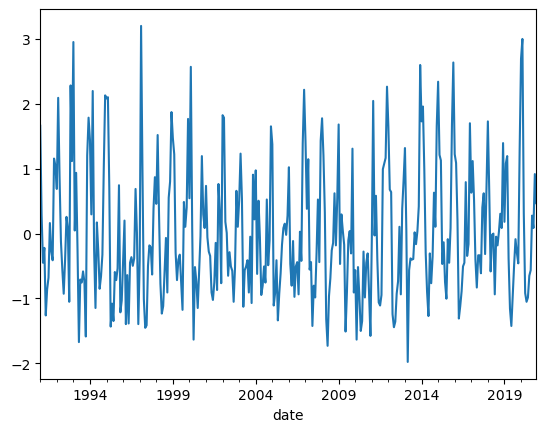

In [4]:
pression_gilbratar_cru  = charger_CRU_fichier(url_gilbratar)
pression_islande_cru    = charger_CRU_fichier(url_islande)
pression_gilbratar_era5 = charger_ERA5_fichier('Gibraltar')
pression_islande_era5   = charger_ERA5_fichier('Reykjavik')
# Indice NAO brut
nao_cru = calculer_index_nao(pression_gilbratar_cru, pression_islande_cru, période=("1991-01", "2020-12") )
nao_cru.name = "nao"
nao_cru.plot()

J'ai trouvé le répertoire D:\Data\data_copernicus\data_nao.
* J'ai trouvé le fichier era5_Gibraltar_sea_pressure_1940_2025.nc et l'ai chargé...
J'ai trouvé le répertoire D:\Data\data_copernicus\data_nao.
* J'ai trouvé le fichier era5_Reykjavik_sea_pressure_1940_2025.nc et l'ai chargé...
longueurs filtre haut 1020 et filtre bas 1020


<Axes: xlabel='valid_time'>

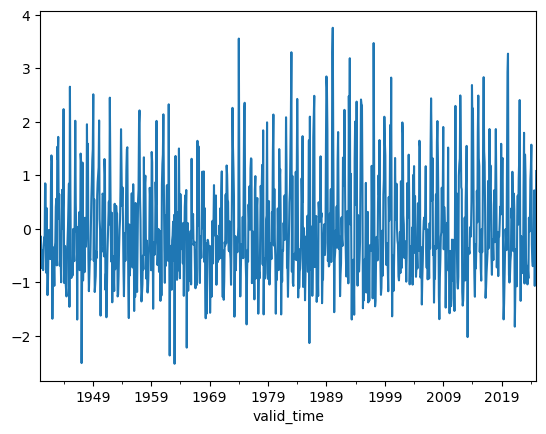

In [5]:
# Indice NAO brut

pression_gilbratar_era5 = charger_ERA5_fichier('Gibraltar',an_début = 1940, durée = 85)
pression_islande_era5   = charger_ERA5_fichier('Reykjavik',an_début = 1940, durée = 85)
nao_era5 = calculer_index_nao(pression_gilbratar_era5, pression_islande_era5, période=("1940-01", "2024-12") )
nao_era5.name = "nao"
nao_era5.plot()

           CRU      ERA5
CRU   1.000000  0.997967
ERA5  0.997967  1.000000


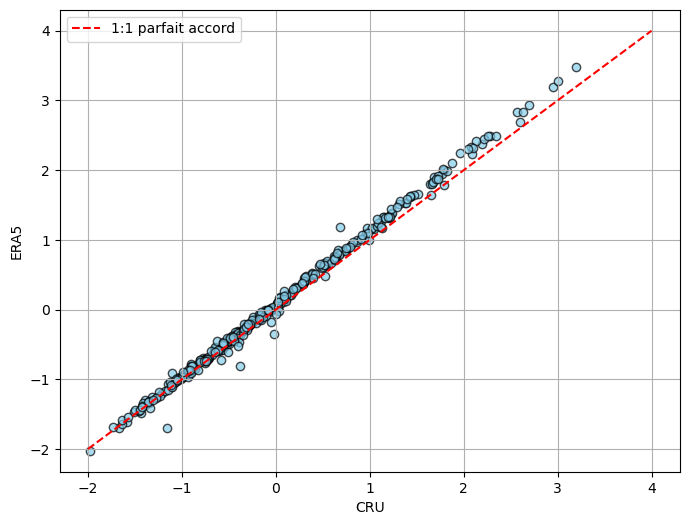

In [6]:
df_compare = pd.concat([nao_cru, nao_era5], axis=1).dropna()
df_compare.columns = ["CRU", "ERA5"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["CRU"], df_compare["ERA5"], alpha=0.7, edgecolor='k',color='skyblue')
plt.plot([-2,4], [-2,4], 'r--', label='1:1 parfait accord')
plt.xlabel("CRU")
plt.ylabel("ERA5")
plt.grid(True)
plt.legend()
plt.show()

## UCAR et NOAA

Le fichier nao_station_monthly.txt existe déjà dans D:\Data\data_copernicus\data_nao.
Le fichier norm.nao.monthly.b5001.current.ascii existe déjà dans D:\Data\data_copernicus\data_nao.


<Axes: xlabel='date'>

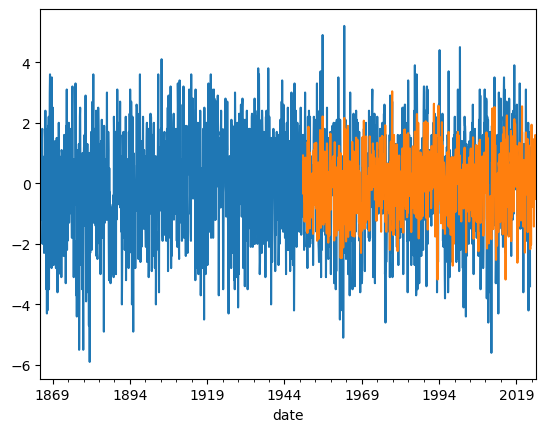

In [7]:
nao_ucar = charger_UCAR_index_NAO()
nao_ucar.plot()
nao_noaa = charger_NOAA_index_NAO()
nao_noaa.plot()

longueurs filtre haut 1020 et filtre bas 1020
          UCAR      ERA5
UCAR  1.000000  0.644293
ERA5  0.644293  1.000000


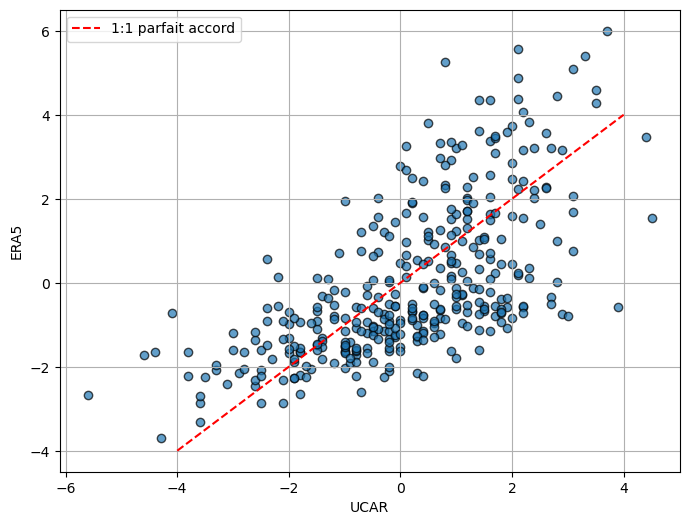

In [8]:
# avec calcul classique de l'index
nao_era5_bis = calculer_index_nao(pression_gilbratar_era5, pression_islande_era5, période=("1991-01", "2020-12"),méthode_classique=False )
nao_era5_bis.name = "nao"


df_compare = pd.concat([nao_ucar, nao_era5_bis], axis=1).dropna()
df_compare.columns = ["UCAR", "ERA5"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["UCAR"], df_compare["ERA5"], alpha=0.7, edgecolor='k')
plt.plot([-4,4], [-4,4], 'r--', label='1:1 parfait accord')
plt.xlabel("UCAR")
plt.ylabel("ERA5")
plt.grid(True)
plt.legend()
plt.show()

          UCAR      NOAA
UCAR  1.000000  0.691579
NOAA  0.691579  1.000000


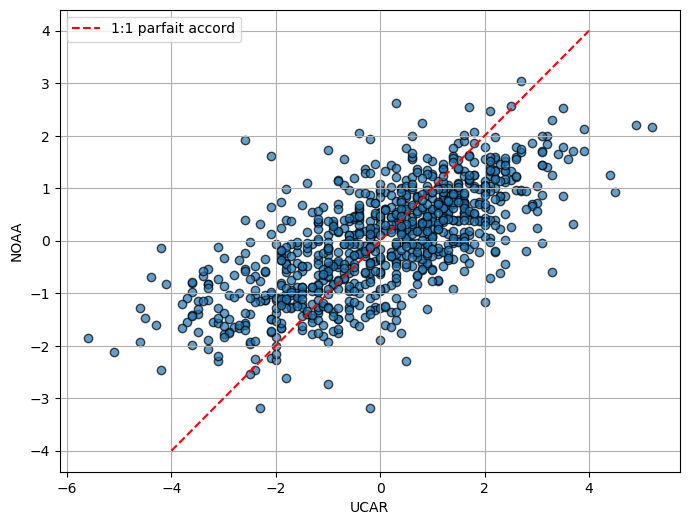

In [9]:
# comparaison UCAR et NOAA
df_compare = pd.concat([nao_ucar, nao_noaa], axis=1).dropna()
df_compare.columns = ["UCAR", "NOAA"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["UCAR"], df_compare["NOAA"], alpha=0.7, edgecolor='k')
plt.plot([-4,4], [-4,4], 'r--', label='1:1 parfait accord')
plt.xlabel("UCAR")
plt.ylabel("NOAA")
plt.grid(True)
plt.legend()
plt.show()

## East Atlantic (EA) et UCAR

In [10]:
ea_series = load_ea_index( )

print(ea_series.head())
print(ea_series.index.min(), ea_series.index.max())

Fichier déjà présent : ea_index.tim
date
1950-01-01   -2.71
1950-02-01    0.66
1950-03-01    0.82
1950-04-01    0.28
1950-05-01   -0.51
Name: ea, dtype: float64
1950-01-01 00:00:00 2025-06-01 00:00:00


         UCAR       EA
UCAR  1.00000  0.16629
EA    0.16629  1.00000


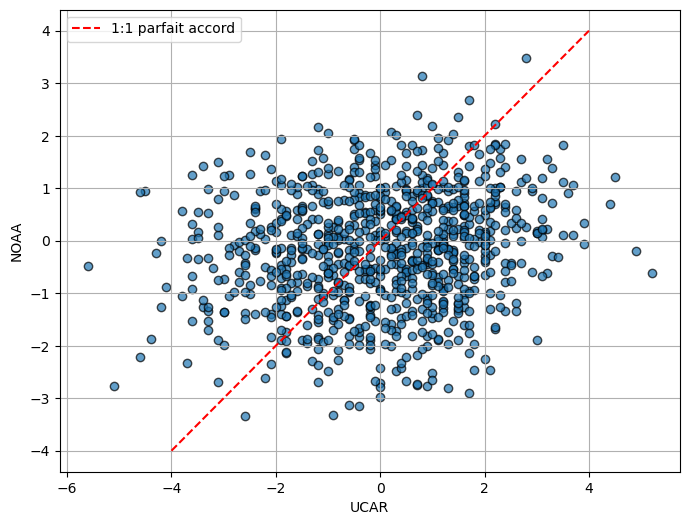

In [11]:
df_compare = pd.concat([nao_ucar, ea_series], axis=1).dropna()
df_compare.columns = ["UCAR", "EA"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["UCAR"], df_compare["EA"], alpha=0.7, edgecolor='k')
plt.plot([-4,4], [-4,4], 'r--', label='1:1 parfait accord')
plt.xlabel("UCAR")
plt.ylabel("NOAA")
plt.grid(True)
plt.legend()
plt.show()

<Axes: xlabel='date'>

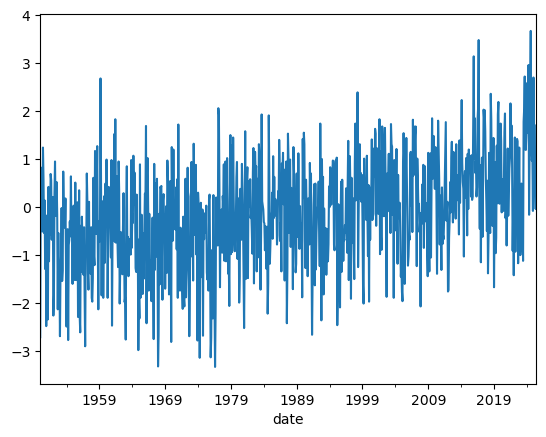

In [12]:
ea_series.plot()

# Analyse pour la Suisse

In [13]:
import statsmodels.api as sm 



def compute_anomalies(ts, ref_start='1940-01', ref_end='2024-12'):
    """
    Calcule les anomalies mensuelles par rapport à une climatologie mensuelle de référence.
    
    - ts : pd.Series avec un index datetime mensuel
    - ref_start / ref_end : période de référence pour la climatologie
    Retourne : pd.Series des anomalies (même index que ts)
    """
    # Sous-série pour la période de référence
    ts_ref = ts[ref_start:ref_end]

    # Climatologie : moyenne pour chaque mois (janvier, février, ..., décembre)
    climatology = ts_ref.groupby(ts_ref.index.month).mean()

    # Anomalies : on soustrait à chaque mois la moyenne correspondante
    anomalies = ts.copy()
    anomalies = anomalies.groupby(anomalies.index.month).transform(lambda x: x - climatology[x.index[0].month])
    
    return anomalies

def assemble_precip_nao_ea(precip_ts, nao_ts, ea_ts):
    df = pd.concat([precip_ts, nao_ts, ea_ts], axis=1)
    df.columns = ['precip', 'nao', 'ea']
    return df.dropna()



def regression_model(df):
    X = sm.add_constant(df[['nao', 'ea']])
    model = sm.OLS(df['precip'], X).fit()
    return model



In [14]:
def télécharger_era5_suisse_precip_mensuelles(fichier, répertoire = répertoire_nao, an_début = 1940, an_fin = 2024,extension = [48, 5, 45, 11]):
    """ charge les données mensuelles pour la suisse"""
    années = range(an_début, an_fin+1)
    c = cdsapi.Client()
    répertoire = Path(répertoire)
    répertoire.parent.mkdir(parents=True, exist_ok=True)
    nom_complet = répertoire / fichier
    c.retrieve(
        'reanalysis-era5-single-levels-monthly-means',
        {
            'product_type': 'monthly_averaged_reanalysis',
            'variable': 'total_precipitation',
            'year': [str(a) for a in années],
            'month': [f"{m:02d}" for m in range(1, 13)],
            'time': '00:00',
            'format': 'netcdf',
            'area': extension,  # N, W, S, E (covers Switzerland)
        },
        str(nom_complet)
    )

def calculer_moyenne_suisse(fichier='era5_precipitation_suisse.nc', extension=[48, 5, 45, 11],
                     répertoire = répertoire_nao, verbosité = True,  an_début = 1940,an_fin = 2024):
    """
    Charge ou télécharge les données de précipitation ERA5 pour 1940--2024
    et calcule la précipitation mensuelle moyenne. Le DCS fournit une valeur de précipitations sous la forme de précipitation moyenne journalière en mm/jour.
    L'unité employée par le CDS est donc fausse. On fait ici la conversion en mm/mois.
    Entrées 
    * fichier à lire ou créer
    * extension : lat_max,lon_min, lat_min, lon_max. Par défaut : extension = [48, 5, 45, 11]. C'est le format (bizarre) du CDS !
    * répertoire : où placer les données
    * verbosité : Boolean. Si True, affiche les messages (pour le débogage)
    * an_début : début de la période de référence. Par défaut 1940
    * an_fin : fin de la période de référence. Par défaut 2024 ans
    Sortie
    """
    # teste si le répertoire existe
    if not os.path.exists(répertoire):
        os.makedirs(répertoire)
    if verbosité: print("J'ai créé le répertoire : ", répertoire)
   
    nom_complet = Path(répertoire) / fichier
    if not nom_complet.exists():
        os.chdir(répertoire)
        if verbosité: print(f"* Téléchargement des données de précipitation entre {an_début} et {an_fin}...")
        télécharger_era5_suisse_precip_mensuelles(fichier = fichier, répertoire = répertoire, 
                                                  an_début = an_début, an_fin = an_fin,extension = extension)
    else:
        if verbosité: print(f"* J'ai trouvé le fichier {fichier} et l'ai chargé...")
    
    ds = xr.open_dataset(nom_complet)
    ds.load()
    ds = xr.open_dataset(Path(répertoire) / fichier)
    da = ds['tp']  # m/jour

    # Moyenne spatiale sur la Suisse
    da_mean = da.mean(dim=["latitude", "longitude"])

    # Conversion en DataFrame pour faciliter le traitement
    df = da_mean.to_series()
    df.name = "tp_m_per_day"

    # Récupération du nombre de jours par mois
    days_per_month = df.index.to_series().index.days_in_month

    # Précipitation mensuelle totale en mm
    df_precip_mm = df * days_per_month * 1000
    df_precip_mm.name = "precip"
    df_precip_mm.index = df_precip_mm.index.normalize()

    return df_precip_mm

def calculer_djf_moyenne(series,name):
    df = series.to_frame()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['year_adj'] = df['year']
    df.loc[df['month'] == 12, 'year_adj'] += 1  # Décembre → hiver de l’année suivante
    df_djf = df[df['month'].isin([12,1,2])].groupby('year_adj').mean(name)
    df_djf.index.name = 'year'
    return df_djf[name]

def calculer_djfm_moyenne(series,name):
    df = series.to_frame()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['year_adj'] = df['year']
    df.loc[df['month'] == 12, 'year_adj'] += 1  # Décembre → hiver de l’année suivante
    df_djfm = df[df['month'].isin([12,1,2,3])].groupby('year_adj').mean(name)
    df_djfm.index.name = 'year'
    return df_djfm[name]

J'ai créé le répertoire :  D:\Data\data_copernicus\data_nao
* J'ai trouvé le fichier era5_precip_suisse_1940_2024.nc et l'ai chargé...


<Axes: xlabel='valid_time'>

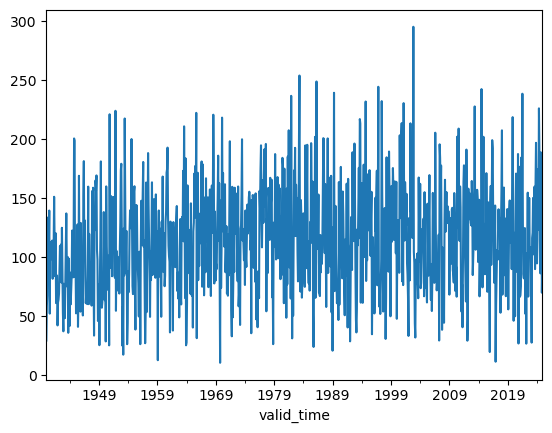

In [15]:

fichier_nc = "era5_precip_suisse_1940_2024.nc"

precip = calculer_moyenne_suisse(fichier_nc)
precip.plot()

          Suisse        EA
Suisse  1.000000  0.108108
EA      0.108108  1.000000
--------------------------
          Suisse       NAO
Suisse  1.000000  0.215226
NAO     0.215226  1.000000


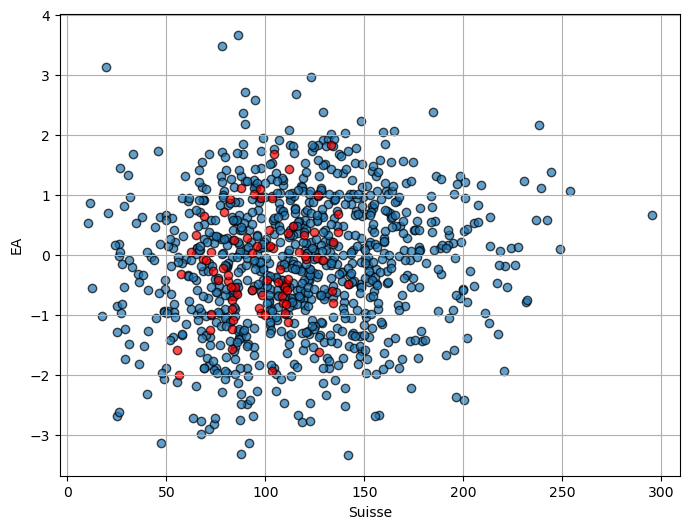

In [16]:
df_compare = pd.concat([precip, ea_series], axis=1).dropna()
df_compare.columns = ["Suisse", "EA"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["Suisse"], df_compare["EA"], alpha=0.7, edgecolor='k')

plt.xlabel("Suisse")
plt.ylabel("EA")
plt.grid(True)


df_compare = pd.concat([calculer_djfm_moyenne(precip,'precip'), calculer_djfm_moyenne(ea_series,'ea')], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO"]
print('--------------------------')
print(df_compare.corr())
plt.scatter(df_compare["Suisse"], df_compare["NAO"], alpha=0.7, edgecolor='k',color='red')


plt.show()

In [17]:
ea_series

date
1950-01-01   -2.71
1950-02-01    0.66
1950-03-01    0.82
1950-04-01    0.28
1950-05-01   -0.51
              ... 
2025-02-01    0.65
2025-03-01    0.81
2025-04-01    0.44
2025-05-01   -0.04
2025-06-01    1.70
Name: ea, Length: 906, dtype: float64

          Suisse       NAO
Suisse  1.000000 -0.272564
NAO    -0.272564  1.000000
--------------------------
          Suisse       NAO
Suisse  1.000000 -0.057349
NAO    -0.057349  1.000000


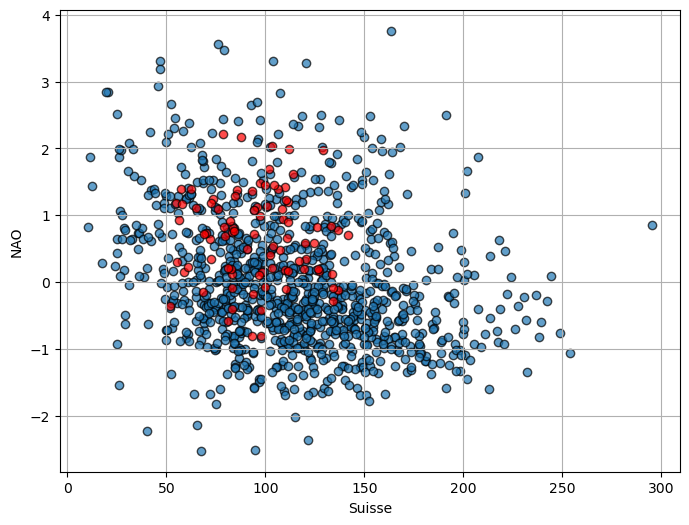

In [18]:
df_compare = pd.concat([precip, nao_era5], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["Suisse"], df_compare["NAO"], alpha=0.7, edgecolor='k')

plt.xlabel("Suisse")
plt.ylabel("NAO")
plt.grid(True)


df_compare = pd.concat([calculer_djfm_moyenne(precip,'precip'), calculer_djfm_moyenne(nao_era5,'nao')], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO"]
print('--------------------------')
print(df_compare.corr())
plt.scatter(df_compare["Suisse"], df_compare["NAO"], alpha=0.7, edgecolor='k',color='red')

 
plt.show()

          Suisse       NAO
Suisse  1.000000  0.030359
NAO     0.030359  1.000000


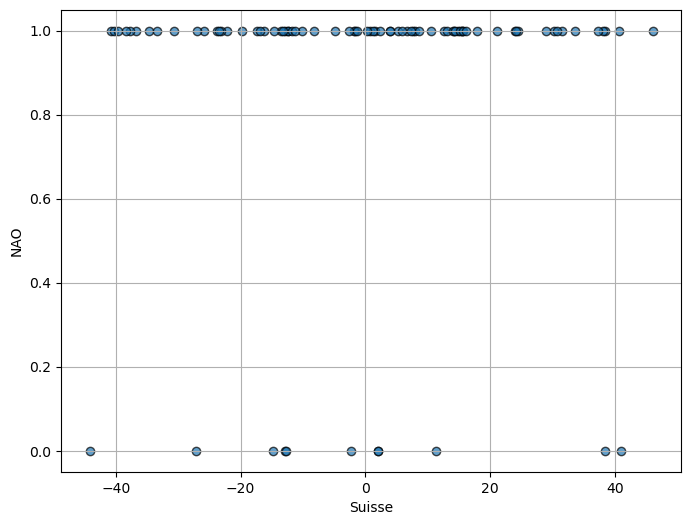

In [19]:
anomalies      = calculer_djfm_moyenne(precip,'precip')-calculer_djfm_moyenne(precip,'precip').mean()
indice_binaire = calculer_djf_moyenne(nao_era5,'nao').apply(lambda x: 0 if x<0 else 1)
df_compare = pd.concat([anomalies, indice_binaire], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["Suisse"], df_compare["NAO"], alpha=0.7, edgecolor='k')

plt.xlabel("Suisse")
plt.ylabel("NAO")
plt.grid(True)

plt.show()

<Axes: xlabel='year'>

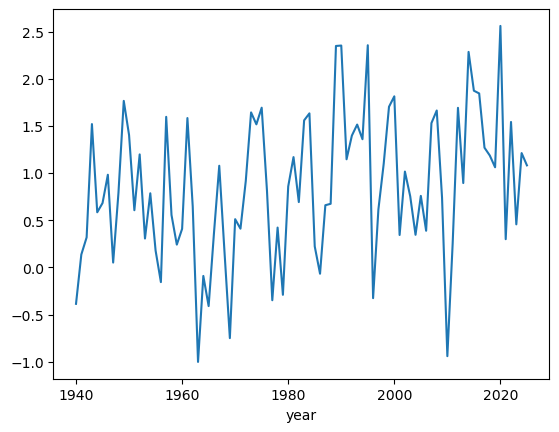

In [20]:
calculer_djf_moyenne(nao_era5,'nao').plot()

          Suisse       NAO
Suisse  1.000000  0.261953
NAO     0.261953  1.000000


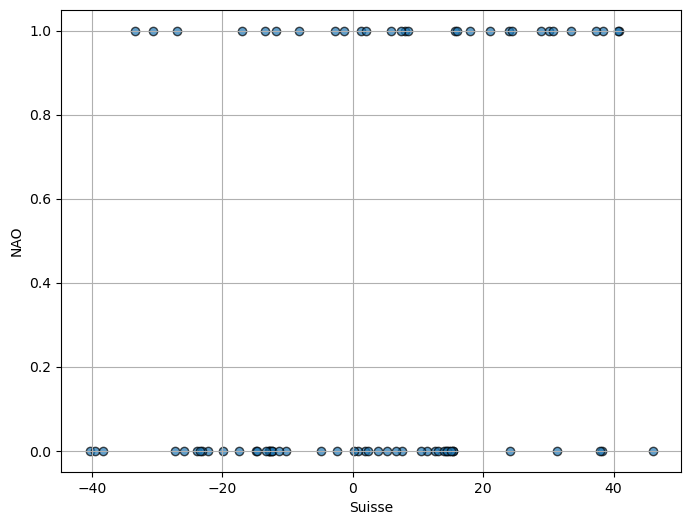

In [21]:
anomalies      = calculer_djfm_moyenne(precip,'precip')-calculer_djfm_moyenne(precip,'precip').mean()
indice_binaire = calculer_djf_moyenne(ea_series,'ea').apply(lambda x: 0 if x<0 else 1)
df_compare = pd.concat([anomalies, indice_binaire], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_compare["Suisse"], df_compare["NAO"], alpha=0.7, edgecolor='k')

plt.xlabel("Suisse")
plt.ylabel("NAO")
plt.grid(True)

plt.show()

<Axes: xlabel='year'>

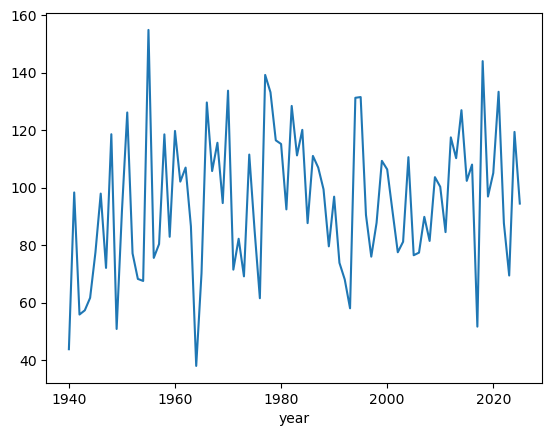

In [22]:
calculer_djf_moyenne(precip,'precip').plot()

In [23]:
calculer_djf_moyenne(nao_era5,'nao')


year
1940   -0.386331
1941    0.136295
1942    0.318004
1943    1.519498
1944    0.584295
          ...   
2021    0.298977
2022    1.542017
2023    0.456390
2024    1.211919
2025    1.081811
Name: nao, Length: 86, dtype: float32

In [24]:
df = nao_era5.to_frame()
df

,nao
valid_time,
1940-01-01,-0.633363
1940-02-01,-0.139300
1940-03-01,-0.306063
1940-04-01,-0.593876
1940-05-01,-0.737789
...,...
2024-08-01,0.720275
2024-09-01,-1.066448
2024-10-01,0.229763


          Suisse       NAO        EA
Suisse  1.000000 -0.275996  0.108108
NAO    -0.275996  1.000000  0.206094
EA      0.108108  0.206094  1.000000
--------------------------
          Suisse       NAO        EA
Suisse  1.000000 -0.110172  0.215226
NAO    -0.110172  1.000000  0.299612
EA      0.215226  0.299612  1.000000


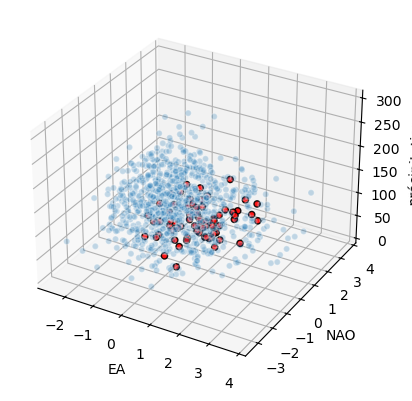

In [25]:
df_compare = pd.concat([precip, nao_era5,ea_series], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO","EA"]

print(df_compare.corr())

# Graphique
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_compare["NAO"], df_compare["EA"], df_compare["Suisse"], alpha=0.25, edgecolor='white')

ax.set_xlabel("EA")
ax.set_ylabel("NAO")
ax.set_zlabel("précipitation")
plt.grid(True)


df_compare = pd.concat([calculer_djfm_moyenne(precip,'precip'), calculer_djfm_moyenne(nao_era5,'nao'), calculer_djfm_moyenne(ea_series,'ea')], axis=1).dropna()
df_compare.columns = ["Suisse", "NAO","EA"]
print('--------------------------')
print(df_compare.corr())
ax.scatter( df_compare["NAO"],df_compare["EA"], df_compare["Suisse"],alpha=0.9, edgecolor='k',color='red')

 


In [26]:

def régression_linéaire(precip, nao_era5, ea_series):
    anomalies = calculer_djfm_moyenne(precip,'precip')-calculer_djfm_moyenne(precip,'precip').mean()
    nao       = calculer_djfm_moyenne(nao_era5,'nao')
    ea        = calculer_djfm_moyenne(ea_series,'ea')
    df = pd.concat([anomalies, nao, ea], axis=1).dropna()
    df.columns = ['precip', 'nao', 'ea']
    X = sm.add_constant(df[['nao', 'ea']])
    model = sm.OLS(df['precip'], X).fit()
    print(model.summary())
    return model

model = régression_linéaire(precip, nao_era5, ea_series)

                            OLS Regression Results                            
Dep. Variable:                 precip   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     3.167
Date:                Tue, 02 Sep 2025   Prob (F-statistic):             0.0480
Time:                        12:04:35   Log-Likelihood:                -337.70
No. Observations:                  76   AIC:                             681.4
Df Residuals:                      73   BIC:                             688.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4284      3.752      2.246      0.0

## Analyse fréquentielle

In [27]:
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Parameters
    ----------
    window : int
        The length of the filter window.
    cutoff : float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1.0, n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2.0 * np.pi * cutoff * k) / (np.pi * k)
    w[n - 1 : 0 : -1] = firstfactor * sigma
    w[n + 1 : -1] = firstfactor * sigma
    return w[1:-1]

In [28]:
cumul_hiver = calculer_djfm_moyenne(precip,'precip')
cumul_hiver.index = pd.to_datetime(cumul_hiver.index, format='%Y')
# array sur la saison hivernale
da_hiver = xr.DataArray(
    np.array(cumul_hiver),
    coords=[
        pd.date_range(
            "1940-01-01",
            periods=len(cumul_hiver),
            freq=pd.DateOffset(years=1),
        )
    ],
    dims="time",
)

da_mensuel = xr.DataArray(
    precip.values,
    coords=[precip.index],
    dims=["time"],
    name="precip",
)

cumul_annuel = precip.groupby(precip.index.year).sum()
cumul_annuel.index = pd.to_datetime(cumul_annuel.index, format='%Y')
da_année = xr.DataArray(
    cumul_annuel.values,
    coords=[cumul_annuel.index],
    dims=["time"],
    name="precip",
)

### Partial autocorrelation

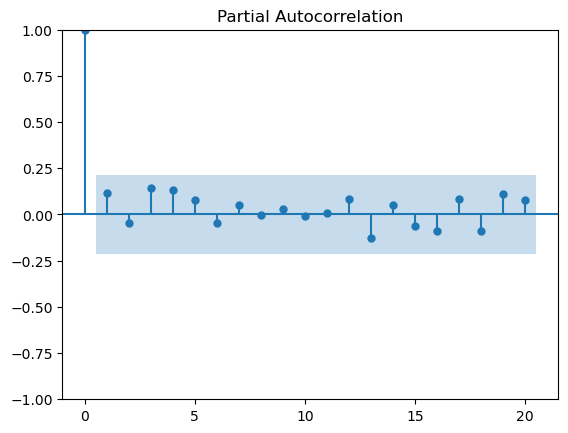

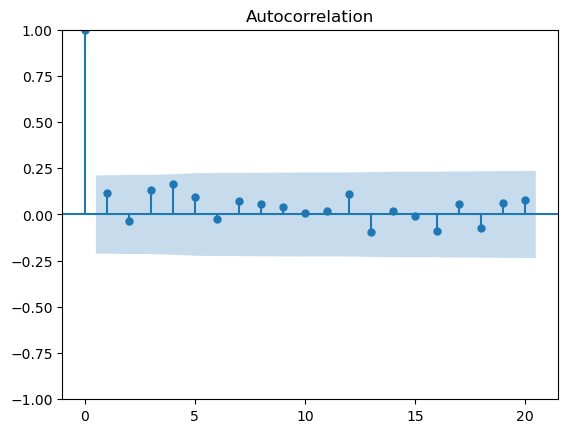

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(cumul_hiver);
plot_acf(cumul_hiver);

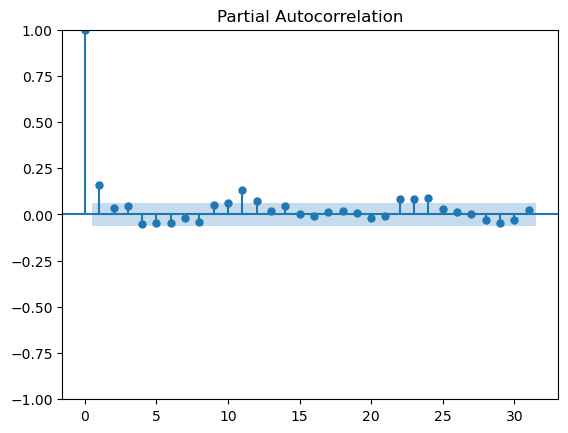

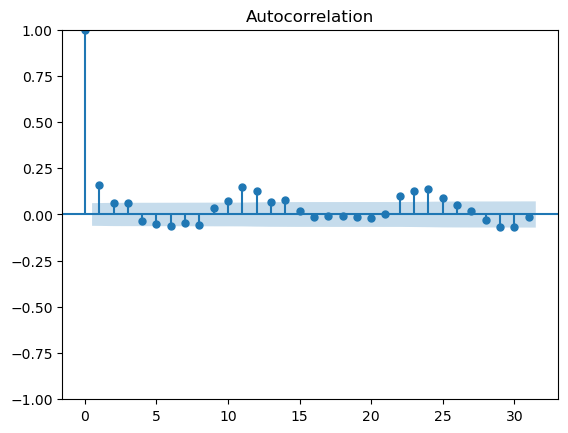

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(precip);
plot_acf(precip);

### Analyse pour les cumuls annuels

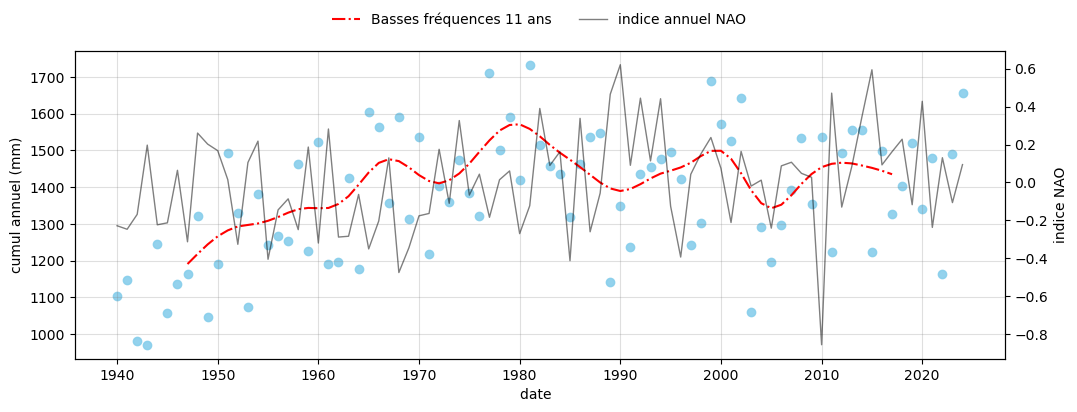

In [31]:
# Window length for filters.
    # construct 3 days and 10 days low pass filters
window = 15
hfw = low_pass_weights(window, 1. / 7.)
lfw = low_pass_weights(window, 1. /11.)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

lowpass_hf = da_année.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = da_année.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)
bandpass_année= da_année.mean()+lowpass_hf - lowpass_lf

fig, axs = plt.subplots(figsize=(12, 4))
# axs.plot(cumul_annuel.index, cumul_annuel, color='skyblue', alpha = 0.9, linewidth = 1.5, 
#          label = "cumul annuel" )

axs.scatter(cumul_annuel.index, cumul_annuel, color='skyblue', alpha = 0.9, marker = 'o' )

#lowpass_hf.plot.line(ax=axs,color='black',linestyle="-",label = "Hautes fréquences 2 ans" )
lowpass_lf.plot.line(ax=axs,color='red',linestyle="-.",label = "Basses fréquences 11 ans" )
#bandpass_hiver.plot(ax=axs,label = "passe bande" )
 
plt.grid(axis="y", color = 'gray', alpha = 0.25)
plt.grid(axis="x", color = 'gray', alpha = 0.25)
axs.set_xlabel(r"date  ")
axs.set_ylabel(r'cumul annuel (mm)')

# axs.text(0.0, 1.05, '(b)',
#      horizontalalignment='center',
#      verticalalignment='center',
#      transform = axs.transAxes)


ax2 = axs.twinx()   

# tracé des températures
nao_era5_annuel = nao_era5.groupby(nao_era5.index.year).mean()
nao_era5_annuel.index = pd.to_datetime(nao_era5_annuel.index,format='%Y')
color = 'black'
ax2.set_ylabel('indice NAO' )   
ax2.plot(nao_era5_annuel.index, nao_era5_annuel, color=color, alpha = 0.5, linewidth = 1., label = "indice annuel NAO")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc="upper center",ncol=3,frameon=False)

In [33]:
fig.savefig("cumul_annuel_suisse+NAO.png",dpi=300)

### Analyse pour les cumuls hivernaux avec indice NAO

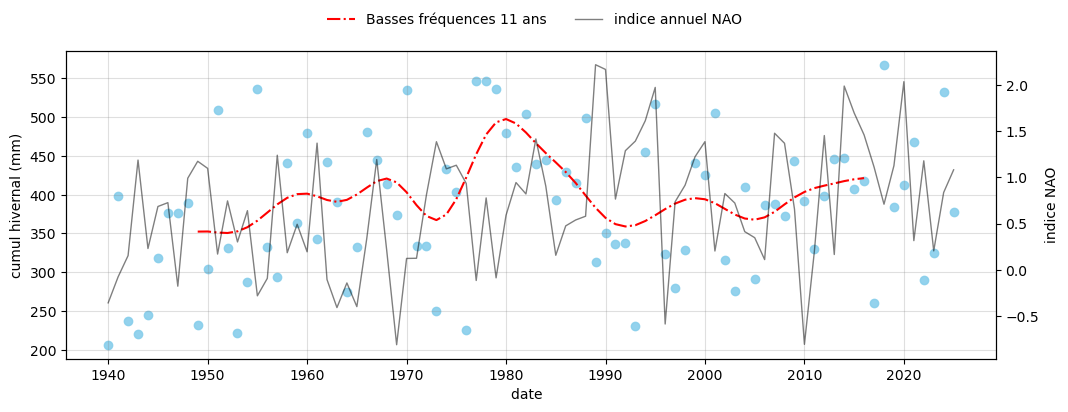

In [34]:
# Window length for filters.
    # construct 3 days and 10 days low pass filters
window = 20
hfw = low_pass_weights(window, 1. / 7.)
lfw = low_pass_weights(window, 1. /11.)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

lowpass_hf = da_hiver.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = da_hiver.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)
bandpass_hiver = da_hiver.mean()+lowpass_hf - lowpass_lf

fig, axs = plt.subplots(figsize=(12, 4))
# axs.plot(cumul_annuel.index, cumul_annuel, color='skyblue', alpha = 0.9, linewidth = 1.5, 
#          label = "cumul annuel" )

axs.scatter(cumul_hiver.index, cumul_hiver*4, color='skyblue', alpha = 0.9, marker = 'o' )

#lowpass_hf.plot.line(ax=axs,color='black',linestyle="-",label = "Hautes fréquences 2 ans" )
#lowpass_lf.plot.line(ax=axs,color='red',linestyle="-.",label = "Basses fréquences 11 ans" )
axs.plot(lowpass_lf.time,lowpass_lf.values*4,color='red',linestyle="-.",label = "Basses fréquences 11 ans" )
#bandpass_hiver.plot(ax=axs,label = "passe bande" )
 
plt.grid(axis="y", color = 'gray', alpha = 0.25)
plt.grid(axis="x", color = 'gray', alpha = 0.25)
axs.set_xlabel(r"date  ")
axs.set_ylabel(r'cumul hivernal (mm)')

# axs.text(0.0, 1.05, '(b)',
#      horizontalalignment='center',
#      verticalalignment='center',
#      transform = axs.transAxes)


ax2 = axs.twinx()   

# tracé des nao
nao_era5_hiver = calculer_djfm_moyenne(nao_era5,'nao')
nao_era5_hiver.index = pd.to_datetime(nao_era5_hiver.index,format='%Y')
color = 'black'
ax2.set_ylabel('indice NAO' )   
ax2.plot(nao_era5_hiver.index, nao_era5_hiver, color=color, alpha = 0.5, linewidth = 1., label = "indice annuel NAO")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc="upper center",ncol=3,frameon=False)

In [35]:
fig.savefig("cumul_hivernal_suisse+NAO.png",dpi=300)

### Analyse pour les cumuls hivernaux avec indice EA

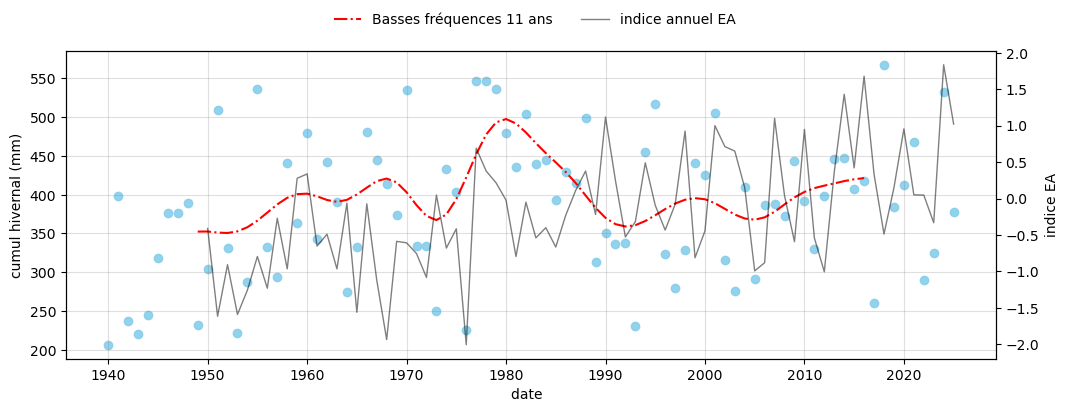

In [36]:
# Window length for filters.
    # construct 3 days and 10 days low pass filters
window = 20
hfw = low_pass_weights(window, 1. / 7.)
lfw = low_pass_weights(window, 1. /11.)
weight_high = xr.DataArray(hfw, dims = ['window'])
weight_low = xr.DataArray(lfw, dims = ['window'])

lowpass_hf = da_hiver.rolling(time = len(hfw), center = True).construct('window').dot(weight_high)
lowpass_lf = da_hiver.rolling(time = len(lfw), center = True).construct('window').dot(weight_low)
bandpass_hiver = da_hiver.mean()+lowpass_hf - lowpass_lf

fig, axs = plt.subplots(figsize=(12, 4))
# axs.plot(cumul_annuel.index, cumul_annuel, color='skyblue', alpha = 0.9, linewidth = 1.5, 
#          label = "cumul annuel" )

axs.scatter(cumul_hiver.index, cumul_hiver*4, color='skyblue', alpha = 0.9, marker = 'o' )

#lowpass_hf.plot.line(ax=axs,color='black',linestyle="-",label = "Hautes fréquences 2 ans" )
#lowpass_lf.plot.line(ax=axs,color='red',linestyle="-.",label = "Basses fréquences 11 ans" )
axs.plot(lowpass_lf.time,lowpass_lf.values*4,color='red',linestyle="-.",label = "Basses fréquences 11 ans" )
#bandpass_hiver.plot(ax=axs,label = "passe bande" )
 
plt.grid(axis="y", color = 'gray', alpha = 0.25)
plt.grid(axis="x", color = 'gray', alpha = 0.25)
axs.set_xlabel(r"date  ")
axs.set_ylabel(r'cumul hivernal (mm)')

# axs.text(0.0, 1.05, '(b)',
#      horizontalalignment='center',
#      verticalalignment='center',
#      transform = axs.transAxes)


ax2 = axs.twinx()   

# tracé des nao
ea_series_hiver = calculer_djfm_moyenne(ea_series,'ea')
ea_series_hiver.index = pd.to_datetime(ea_series_hiver.index,format='%Y')
color = 'black'
ax2.set_ylabel('indice EA' )   
ax2.plot(ea_series_hiver.index, ea_series_hiver, color=color, alpha = 0.5, linewidth = 1., label = "indice annuel EA")
ax2.tick_params(axis='y', labelcolor=color)
fig.legend(loc="upper center",ncol=3,frameon=False)

In [37]:
fig.savefig("cumul_hivernal_suisse+EA.png",dpi=300)

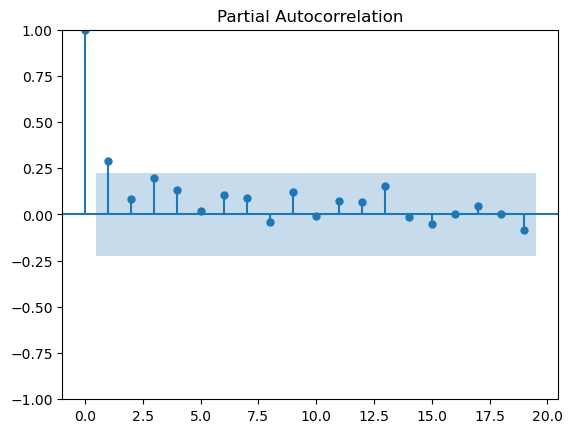

In [164]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(ea_series_hiver);
 